In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:
import os
print(os.getcwd())

c:\Users\thsat\sat_imagery_ml\sat-imagery-ml-1\3_Model


In [3]:
from PIL import Image

image_path = r'C:\Users\thsat\sat_imagery_ml\sat-imagery-ml-1\1_DatasetCharacteristics\EruptionImages\sorted images\test\activity_no\Barren_Island_22187_2016-04-21.png'

with Image.open(image_path) as img:
    print("Image size:", img.size)  # (width, height)
    print("Image mode:", img.mode)  # e.g., 'RGB', 'RGBA', 'L'


Image size: (512, 468)
Image mode: RGBA


In [4]:
from PIL import Image
import numpy as np

image_path = r'C:\Users\thsat\sat_imagery_ml\sat-imagery-ml-1\1_DatasetCharacteristics\EruptionImages\sorted images\test\activity_no\Barren_Island_22187_2016-04-21.png'

with Image.open(image_path) as img:
    # Convert from RGBA to RGB (drops alpha)
    img_rgb = img.convert('RGB')
    image_array = np.array(img_rgb)

print("New image shape:", image_array.shape)  # Should be (224, 224, 3)

New image shape: (468, 512, 3)


In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

dataset_dir = r'C:\Users\thsat\sat_imagery_ml\sat-imagery-ml-1\1_DatasetCharacteristics\EruptionImages\sorted images\train_val'

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Load dataset and split
train_ds = image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    label_mode='binary',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    label_mode='binary',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Optimize dataset pipeline
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)


Found 830 files belonging to 2 classes.
Using 664 files for training.
Found 830 files belonging to 2 classes.
Using 166 files for validation.


# plot classes

Found 830 files belonging to 2 classes.
Using 664 files for training.
Found 830 files belonging to 2 classes.
Using 166 files for validation.
Class names: ['activity_no', 'activity_yes']


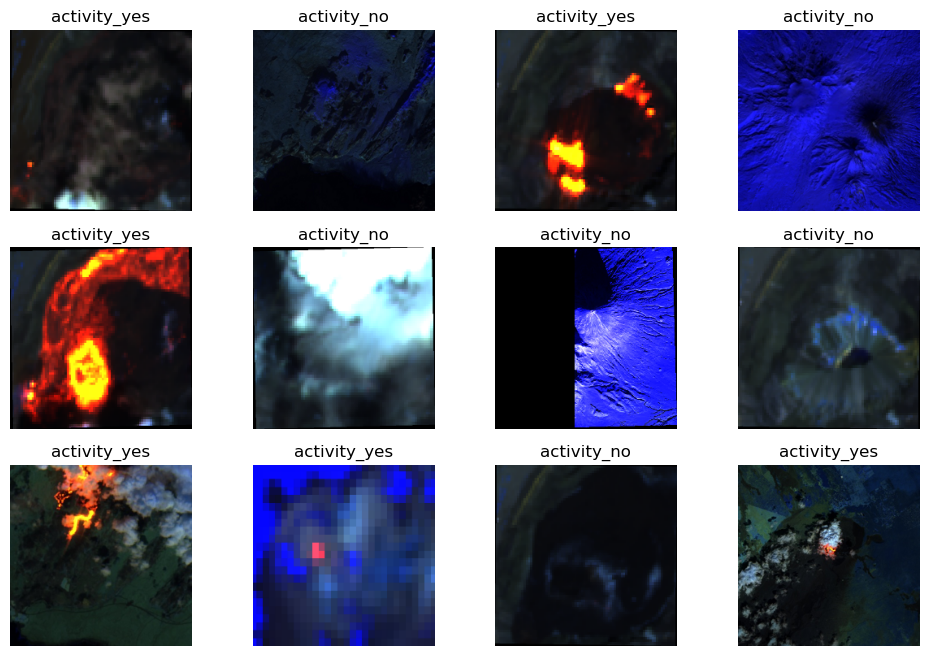

In [7]:
train_ds_raw = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    label_mode='binary',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds_raw = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    label_mode='binary',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Save class names before prefetch
class_names = train_ds_raw.class_names
print("Class names:", class_names)

# Prefetch separately
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds_raw.prefetch(AUTOTUNE)
val_ds = val_ds_raw.prefetch(AUTOTUNE)


import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

for images, labels in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        label = int(labels[i])
        plt.title(class_names[label])
        plt.axis("off")


# model

In [13]:
# Load base MobileNetV2
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # freeze for transfer learning

# Build your classifier
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')  # binary classification
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


# train the model

In [14]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10


21/21 [==============================] - 20s 830ms/step - loss: 0.9395 - accuracy: 0.5181 - val_loss: 0.7253 - val_accuracy: 0.5723
Epoch 2/10
21/21 [==============================] - 19s 882ms/step - loss: 0.8013 - accuracy: 0.5648 - val_loss: 0.6120 - val_accuracy: 0.6988
Epoch 3/10
21/21 [==============================] - 15s 714ms/step - loss: 0.7042 - accuracy: 0.5934 - val_loss: 0.5694 - val_accuracy: 0.7108
Epoch 4/10
21/21 [==============================] - 14s 681ms/step - loss: 0.6689 - accuracy: 0.6280 - val_loss: 0.5491 - val_accuracy: 0.7229
Epoch 5/10
21/21 [==============================] - 13s 635ms/step - loss: 0.6403 - accuracy: 0.6431 - val_loss: 0.5337 - val_accuracy: 0.7349
Epoch 6/10
21/21 [==============================] - 15s 724ms/step - loss: 0.6383 - accuracy: 0.6566 - val_loss: 0.5196 - val_accuracy: 0.7289
Epoch 7/10
21/21 [==============================] - 14s 680ms/step - loss: 0.6219 - accuracy: 0.6596 - val_loss: 0.5068 - val_accuracy: 0.7470
Epoch 8/10

# evaluate

In [ ]:
base_model.trainable = True

# Recompile with a lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Fine-tune
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
21/21 [==============================] - 67s 3s/step - loss: 0.1124 - accuracy: 0.9729 - val_loss: 0.1976 - val_accuracy: 0.9277
Epoch 2/10
21/21 [==============================] - 60s 3s/step - loss: 0.1045 - accuracy: 0.9834 - val_loss: 0.1757 - val_accuracy: 0.9398
Epoch 3/10
21/21 [==============================] - 59s 3s/step - loss: 0.0866 - accuracy: 0.9789 - val_loss: 0.1552 - val_accuracy: 0.9578
Epoch 4/10
21/21 [==============================] - 59s 3s/step - loss: 0.0611 - accuracy: 0.9849 - val_loss: 0.1426 - val_accuracy: 0.9578
Epoch 5/10
21/21 [==============================] - 59s 3s/step - loss: 0.0626 - accuracy: 0.9880 - val_loss: 0.1285 - val_accuracy: 0.9759
Epoch 6/10
21/21 [==============================] - 58s 3s/step - loss: 0.0458 - accuracy: 0.9940 - val_loss: 0.1187 - val_accuracy: 0.9759
Epoch 7/10
21/21 [==============================] - 61s 3s/step - loss: 0.0377 - accuracy: 1.0000 - val_loss: 0.1120 - val_accuracy: 0.9759
Epoch 8/10
21/21 [==

1/1 [==============================] - 2s 2s/step


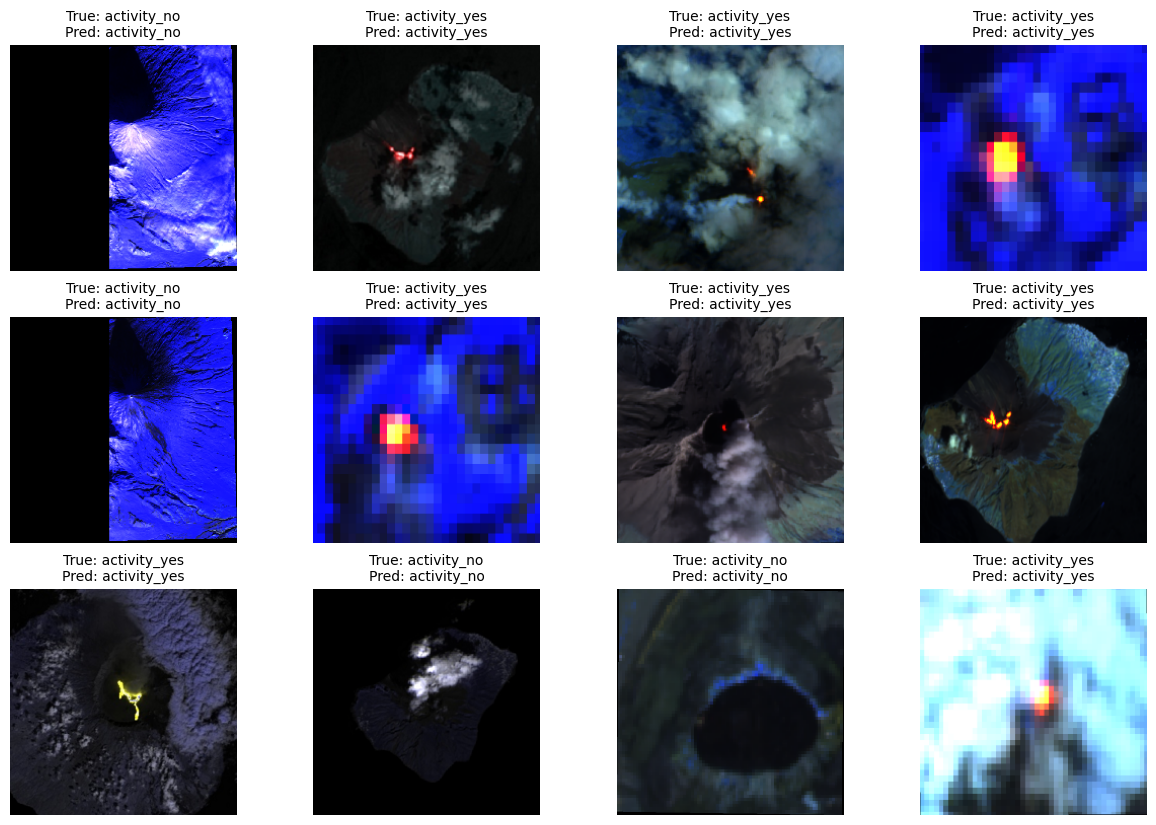

In [21]:
import matplotlib.pyplot as plt
import numpy as np

for images, labels in val_ds.take(1):
    predictions = model.predict(images)
    predicted_labels = (predictions.flatten() >= 0.5).astype(int)

    plt.figure(figsize=(15, 10))
    for i in range(min(12, len(images))):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        true_label = int(labels[i].numpy())
        pred_label = predicted_labels[i]
        title = f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}"
        plt.title(title, fontsize=10)
        plt.axis("off")
    break 


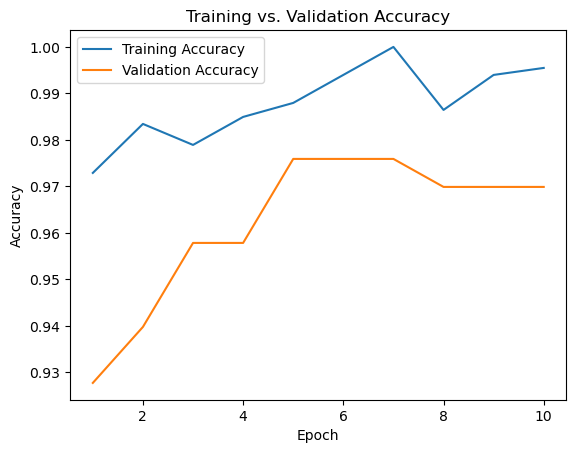

In [22]:
import matplotlib.pyplot as plt

# Get accuracy values
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs_range = range(1, len(acc) + 1)

# Plot
plt.figure()
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.legend()
plt.show()


In [ ]:
# Plot training & validation accuracy values for both models of above
plt.figure(figsize=(12, 6))

# Plot accuracy for the first model
plt.plot(history.history['accuracy'], 'b-', label='Train accuracy Base Model')
plt.plot(history.history['val_accuracy'], 'b--', label='Validation accuracy Base Model')

# Plot accuracy for the second model
plt.plot(history_val_split.history['accuracy'], 'r-', label='Train accuracy Validation Split Model')
plt.plot(history_val_split.history['val_accuracy'], 'r--', label='Validation accuracy Validation Split Model')

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()